<a href="https://colab.research.google.com/github/jgamel/learn_n_dev/blob/simulation_examples/SimPy_Parallel_Queueing_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulating a Parallel Queueing System With SimPy

### SimPy Preliminaries

SimPy is a Discrete Event Simulation (DES) package for Python. DES refers to a simulation system which will periodically introduce a specified event as it runs, discrete insofar as each event can be thought of as “happened” or “not happened (yet, or ever)”.

In SimPy, the DES system is contained within its Environment class. The user specifies a system which will run for the Environment upon executing Environment.run().
Within the Environment , the user can define Process and Resource objects which will dynamically interact as the DES is run. In particular, Process objects are the generators of the discrete events we will be working with while a Resource defines an object to be interacted with in this DES “universe”.

In Python, generator objects can be thought of as distinct from functions. Whereas functions have the form of (for some manipulation, foo(a), like a+2 ):

In [1]:
def function(a):
    return foo(a)

generators have the form of:

In [2]:
def generator(a):
    yield foo(a)

where yield instead denotes a single output which will not cause the generator itself to stop being considered. To make this clear, it is possible to have:

In [3]:
def generator(a):
    yield foo(a)
    print('Wait, I forgot this!')
    yield bar(a)

which is useful for an object which will be existing in our universe for a period of time. return would instead immediately end the function and output foo(a) .

### Parallel Queueing System Example

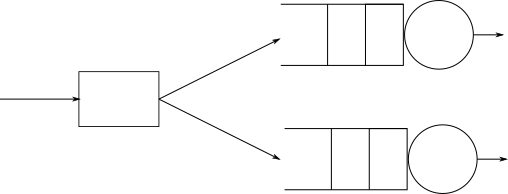

This example is a translation of this example from SimPy Classic. In this scenario, we are implementing what is known as the Join the Shortest Queue (JSQ) algorithm, wherein a job will choose the queue with the smallest wait time. In our DES universe, the jobs will be “Customers” and the servers will be “Counters” at a bank. There are two counters currently servicing patrons and the patrons are smart enough to not to join the bigger of the two lines.

To start, let us run our system until either 30 customers are generated and complete their time in the environment or if some period of time (400 arbitrary units of time) have passed. Let us also choose an average time for each customer to spend in the bank and the mean of our arrival process. For simplicity, we will assume both the service and arrival processes to be exponential.

In [4]:
!pip install simpy

In [5]:
from simpy import *
import random

maxNumber = 30      # Max number of customers
maxTime = 400.0     # Rumtime limit
timeInBank = 20.0   # Mean time in bank
arrivalMean = 10.0  # Mean of arrival process
seed = 12345        # Seed for simulation

Now comes our definition of a Customer, a Process which will be generated by an arrival process. The logic for how the Customer will behave in our simulation is:

In [6]:
def Customer(env, name, counters):
    arrive = env.now
    Qlength = [NoInSystem(counters[i]) for i in range(len(counters))]
    print("%7.4f %s: Here I am. %s" % (env.now, name, Qlength))
    for i in range(len(Qlength)):
        if Qlength[i] == 0 or Qlength[i] == min(Qlength):
            choice = i  # the chosen queue number
            break
    with counters[choice].request() as req:
        # Wait for the counter
        yield req
        wait = env.now - arrive
        # We got to the counter
        print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(1.0 / timeInBank)
        yield env.timeout(tib)
        print('%7.4f %s: Finished' % (env.now, name))


def NoInSystem(R: Resource):
    """Total number of customers in the resource R"""
    return max([0, len(R.put_queue) + len(R.users)])


We begin by logging the arrival time (env=Environment()), followed by using Qlength to store the current queue sizes. The arriving customer then decides to think out loud, printing their arrival time, name, and the length of each queue into our console (his name will be defined later, we are yet to define our arrival process!)

They then choose the smallest of the queues and wait in line ( yield req ). When it gets to their turn, they then rudely exclaim the current time and how long they had waited to the teller. A random service time is then chosen ( tib ) and is modeled by yielding a “timeout” for this time. Following this, our patron states that they are finished and the time, leaving the bank for the great unknown.

As for their arrival process, it is defined as:

In [7]:
def Source(env, number, interval, counters):
    for i in range(number):
        c = Customer(env, 'Customer%02d' % i, counters)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

where number will be filled by our maximum of 30.

Lastly, after initializing our simulation, the program will look like:

In [8]:
"""
Bank with multiple queues example
Covers:
- Resources: Resource
- Iterating processes
Scenario:
  A multi-counter bank with a random service time and customers arrival process. Based on the
  program bank10.py from TheBank tutorial of SimPy 2. (KGM)

"""
from simpy import *
import random

maxNumber = 30      # Max number of customers
maxTime = 400.0     # Rumtime limit
timeInBank = 20.0   # Mean time in bank
arrivalMean = 10.0  # Mean of arrival process
seed = 12345        # Seed for simulation


def Customer(env, name, counters):
    arrive = env.now
    Qlength = [NoInSystem(counters[i]) for i in range(len(counters))]
    print("%7.4f %s: Here I am. %s" % (env.now, name, Qlength))
    for i in range(len(Qlength)):
        if Qlength[i] == 0 or Qlength[i] == min(Qlength):
            choice = i  # the chosen queue number
            break
    with counters[choice].request() as req:
        # Wait for the counter
        yield req
        wait = env.now - arrive
        # We got to the counter
        print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(1.0 / timeInBank)
        yield env.timeout(tib)
        print('%7.4f %s: Finished' % (env.now, name))


def NoInSystem(R):
    """Total number of customers in the resource R"""
    return max([0, len(R.put_queue) + len(R.users)])


def Source(env, number, interval, counters):
    for i in range(number):
        c = Customer(env, 'Customer%02d' % i, counters)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


# Setup and start the simulation
print('Bank with multiple queues')
random.seed(seed)
env = Environment()

counters = [Resource(env), Resource(env)]
env.process(Source(env, maxNumber, arrivalMean, counters))
env.run(until=maxTime)


Bank with multiple queues
 0.0000 Customer00: Here I am. [0, 0]
 0.0000 Customer00: Waited  0.000
 0.2044 Customer00: Finished
 5.3892 Customer01: Here I am. [0, 0]
 5.3892 Customer01: Waited  0.000
12.4838 Customer01: Finished
22.8307 Customer02: Here I am. [0, 0]
22.8307 Customer02: Waited  0.000
27.1357 Customer02: Finished
27.4258 Customer03: Here I am. [0, 0]
27.4258 Customer03: Waited  0.000
30.9531 Customer03: Finished
35.7731 Customer04: Here I am. [0, 0]
35.7731 Customer04: Waited  0.000
37.1001 Customer05: Here I am. [1, 0]
37.1001 Customer05: Waited  0.000
40.9316 Customer05: Finished
45.3572 Customer06: Here I am. [1, 0]
45.3572 Customer06: Waited  0.000
47.1188 Customer04: Finished
53.4141 Customer07: Here I am. [0, 1]
53.4141 Customer07: Waited  0.000
54.1243 Customer06: Finished
55.3288 Customer07: Finished
85.1304 Customer08: Here I am. [0, 0]
85.1304 Customer08: Waited  0.000
95.7551 Customer08: Finished
123.5928 Customer09: Here I am. [0, 0]
123.5928 Customer09: Waite

We see, in this case, that it takes up until t=88 for our queues to begin forming. 

Moreover, the maxTime was not passed as all 30 customers (0 to 29) were first serviced.

## Extension to JSQ(d)

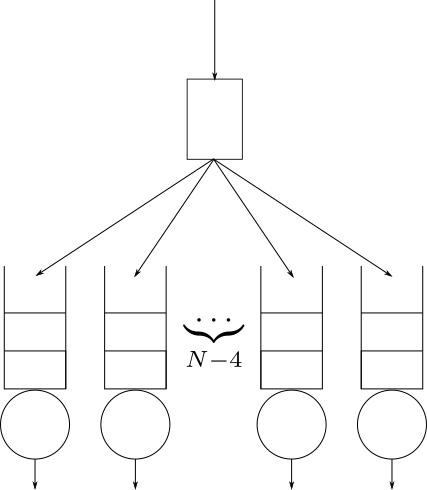

An important advance in network engineering has been the adoption of routing algorithms which do not parse all queues when finding the smallest queue to join. Rather, Join the Shortest Queue-(d) (JSQ(d)) will parse d of the queues and join the shortest of these. In a world where cloud computing networks might have a farm of processors numbering in the hundreds or even thousands, the time needed to parse each can be costly. Such has reigned in the study of “load-balancing” algorithms like JSQ(d).

As an example, let us assume the red dots in the following to represent a job under JSQ(2)

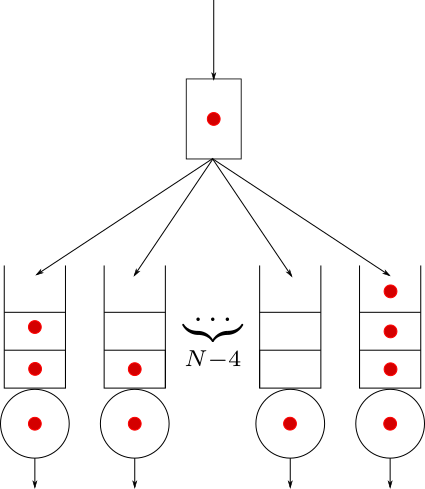

The job which just arrived is placed in the square box and shall now choose its queue by counting the jobs of 2 randomly selected queues. In the following, if the blue circles represent the sampled queues, then clearly the optimal choice is the second queue to the right.

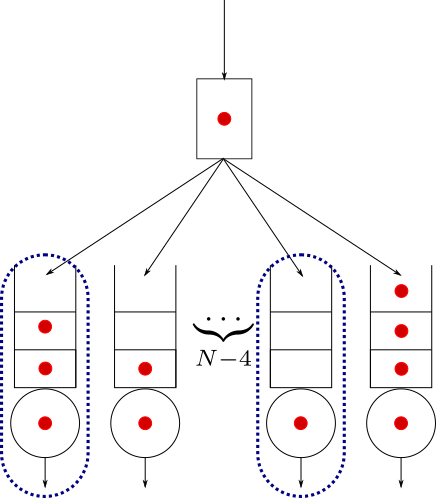

## JSQ(d) in SimPy

JSQ(d) is the easiest load balancing method to extend our bank example. In this case, we only technically need to modify the prior code to include the logic for choosing from a subset of queues.

Noting first the inclusion of doPrint , a parameter which can be set to reduce the amount of output in the console, we arrive at the following modification of the job process:

In [9]:
def job(env, name, counters):
    arrive = env.now
    Qlength = {i: NoInSystem(counters[i]) for i in QueueSelector(d, counters)}
    if doPrint:
        print("%7.4f %s: Arrival " % (arrive, name))
    Queues.append({i: len(counters[i].put_queue) for i in range(len(counters))})
    choice = [k for k, v in sorted(Qlength.items(), key=lambda a: a[1])][0]
    with counters[choice].request() as req:
        # Wait in queue
        yield req
        wait = env.now - arrive
        # We got to the server
        if doPrint:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(1.0 / timeInBank)
        yield env.timeout(tib)
        Queues.append({i: len(counters[i].put_queue) for i in range(len(counters))})
        if doPrint:
            print('%7.4f %s: Finished' % (env.now, name))

In this case,

```
choice = [k for k, v in sorted(Qlength.items(), key=lambda a: a[1])][0]
```

refers to the action of first sorting the items of the dictionary (which are of form ```{queue: queue_size for queue in queues}``` ) from smallest to largest and then selecting the smallest queue now the first item in the list. Do note that in Python, the 0th element refers to the first item in an interable object.

At last, along with the addition of an ```noJobCap``` parameter to allow for easy switching between having or not having a maximum allowed number of jobs in the system, we have:


 Running simulation with seed 204204... 


 Done 



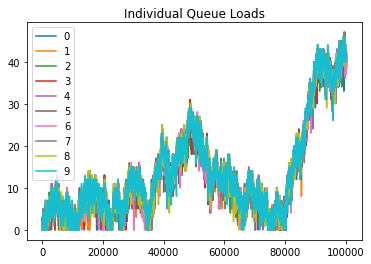

In [11]:
## jsqd.py
"""
A queueing system wherein a job chooses the smallest queue of d sampled queues to join.
This is a so-called load balancing routing algorithm and is meant for larger parallel
systems where parsing all queue sizes would be cost-inefficient
MIT License
ⓒ 2020 Aaron Janeiro Stone
"""
import random
from simpy import *
import pandas as pd
import matplotlib.pyplot as plt

number = 300  # Max number of jobs if infinite is false
noJobCap = True  # For infinite
maxTime = 100000.0  # Runtime limit
timeInBank = 20.0  # Mean time in bank
arrivalMean = 2.0  # Mean of arrival process
seed = 204204  # Seed for RNG
parallelism = 10  # Number of queues
d = 2  # Number of queues to parse
doPrint = False  # True => print every arrival and wait time

if noJobCap == True:
    number = 0

Queues = []


def job(env, name, counters):
    arrive = env.now
    Qlength = {i: NoInSystem(counters[i]) for i in QueueSelector(d, counters)}
    if doPrint:
        print("%7.4f %s: Arrival " % (arrive, name))
    Queues.append({i: len(counters[i].put_queue) for i in range(len(counters))})
    choice = [k for k, v in sorted(Qlength.items(), key=lambda a: a[1])][0]
    with counters[choice].request() as req:
        # Wait in queue
        yield req
        wait = env.now - arrive
        # We got to the server
        if doPrint:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        tib = random.expovariate(1.0 / timeInBank)
        yield env.timeout(tib)
        Queues.append({i: len(counters[i].put_queue) for i in range(len(counters))})
        if doPrint:
            print('%7.4f %s: Finished' % (env.now, name))


def NoInSystem(R):
    """Total number of jobs in the resource R"""
    return len(R.put_queue) + len(R.users)


def QueueSelector(d, counters):
    return random.sample(range(len(counters)), d)


def Source(env, number, interval, counters):
    if noJobCap == False:
        for i in range(number):
            c = job(env, 'job%02d' % i, counters)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)
    else:
        while True:  # Needed for infinite case as True refers to "until".
            i = number
            number += 1
            c = job(env, 'job%02d' % i, counters)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)


# Setup and start the simulation
random.seed(seed)
env = Environment()

counters = {i: Resource(env) for i in range(parallelism)}
env.process(Source(env, number, arrivalMean, counters))
print(f'\n Running simulation with seed {seed}... \n')
env.run(until=maxTime)
print('\n Done \n')

df = pd.DataFrame(Queues).plot()
plt.title("Individual Queue Loads")
plt.show()


Clearly, we can see why this would be considered a “load balancing” algorithm; over time, the workload is distributed evenly across all queues.